In [8]:
# Import Libraries

# Warning
import warnings
warnings.filterwarnings("ignore")

# Main
import os
import glob
import cv2
import numpy as np
import pandas as pd
import gc
import string
import time
import random
import imutils
from PIL import Image
from tqdm import tqdm
tqdm.pandas()

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE

# Model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [10]:
# Configuration
class CFG:
    batch_size = 64
    img_height = 64
    img_width = 64
    epochs = 15
    num_classes = 36
    img_channels = 1
    
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    

# Directory path
TRAIN_PATH = 'data/ASL_Dataset/Train'

# Labels
labels = []

# Get the folder names (which represent the labels)
label_folders = os.listdir(TRAIN_PATH)

# Append the label names from folder names to the labels list
labels.extend(label_folders)

print(labels)


['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'Nothing', 'O', 'P', 'Q', 'R', 'S', 'Space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [11]:
# Create Metadata
list_path = []
list_labels = []
for label in labels:
    label_path = os.path.join(TRAIN_PATH, label, "*")
    image_files = glob.glob(label_path)
    
    sign_label = [label] * len(image_files)
    
    list_path.extend(image_files)
    list_labels.extend(sign_label)

metadata = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

print(metadata)


# Split Dataset to Train 0.7, Val 0.15, and Test 0.15
X_train, X_test, y_train, y_test = train_test_split(
    metadata["image_path"], metadata["label"], 
    test_size=0.15, 
    random_state=2023, 
    shuffle=True, 
    stratify=metadata["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

X_train, X_val, y_train, y_val = train_test_split(
    data_train["image_path"], data_train["label"],
    test_size=0.15/0.70,
    random_state=2023,
    shuffle=True,
    stratify=data_train["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})
data_val = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})
data_test = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})

print(data_train)
print(data_val)
print(data_test)

                               image_path label
0         data/ASL_Dataset/Train\A\10.jpg     A
1        data/ASL_Dataset/Train\A\100.jpg     A
2       data/ASL_Dataset/Train\A\1000.jpg     A
3       data/ASL_Dataset/Train\A\1001.jpg     A
4       data/ASL_Dataset/Train\A\1002.jpg     A
...                                   ...   ...
165665  data/ASL_Dataset/Train\Z\Z995.jpg     Z
165666  data/ASL_Dataset/Train\Z\Z996.jpg     Z
165667  data/ASL_Dataset/Train\Z\Z997.jpg     Z
165668  data/ASL_Dataset/Train\Z\Z998.jpg     Z
165669  data/ASL_Dataset/Train\Z\Z999.jpg     Z

[165670 rows x 2 columns]
                                image_path label
72076    data/ASL_Dataset/Train\M\1110.jpg     M
62100    data/ASL_Dataset/Train\K\2927.jpg     K
93660   data/ASL_Dataset/Train\O\O1651.jpg     O
74576     data/ASL_Dataset/Train\M\664.jpg     M
115934   data/ASL_Dataset/Train\S\2837.jpg     S
...                                    ...   ...
57899   data/ASL_Dataset/Train\J\J1845.jpg     J
14938

In [12]:
# Data Augmentation (Just Rescale)
def data_augmentation():
    datagen = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization=True,
        horizontal_flip=False,
        rotation_range=30,
        shear_range=0.2,
        zoom_range=0.2,  # Zoom in and out
        width_shift_range=0.2,  # Shift images horizontally
        height_shift_range=0.2,  # Shift images vertically
        brightness_range=[0.8, 1.2],  # Randomly change brightness
        fill_mode='nearest'  # Fill in pixels with nearest value
    )
    # Training Dataset
    train_generator = datagen.flow_from_dataframe(
        data_train,
        directory="./",
        x_col="image_path",
        color_mode='grayscale',
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
    )

    # Validation Dataset
    validation_generator = datagen.flow_from_dataframe(
        data_val,
        directory="./",
        x_col="image_path",
        color_mode='grayscale',
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
    )
    
    # Testing Dataset
    test_generator = datagen.flow_from_dataframe(
        data_test,
        directory="./",
        x_col="image_path",
        color_mode='grayscale',
        y_col="label",
        class_mode="categorical",
        batch_size=1,
        target_size=(CFG.img_height, CFG.img_width),
        shuffle=False
    )
    
    return train_generator, validation_generator, test_generator

seed_everything(2023)
train_generator, validation_generator, test_generator = data_augmentation()

Found 110643 validated image filenames belonging to 28 classes.
Found 30176 validated image filenames belonging to 28 classes.
Found 24851 validated image filenames belonging to 28 classes.


# Deep Learning Model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# Define the improved model
model = Sequential()

# First Convolutional Block
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1), padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

# Second Convolutional Block
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

# Third Convolutional Block
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

# Fourth Convolutional Block
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

# Fifth Convolutional Block (Optional for more complexity)
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Increase dropout to prevent overfitting
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(28, activation='softmax'))

# Model Summary
model.summary()


# Visualize the model architecture
print(tf.keras.utils.plot_model(model, to_file='custom_cnn.png', show_shapes=True))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and model checkpointing
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
checkpoint = ModelCheckpoint('custom_cnn_best_weights.keras', save_best_only=True, monitor='val_accuracy', mode='max')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // CFG.batch_size,
    epochs=CFG.epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // CFG.batch_size,
    callbacks=[checkpoint]
)

# Save the trained model
model.save('cnn_sign_language.h5')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 2, 2, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 28)             │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,133,020 (8.14 MB)

 Trainable params: 2,131,036 (8.13 MB)

 Non-trainable params: 1,984 (7.75 KB)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
None
Epoch 1/15
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 319s 183ms/step - accuracy: 0.4780 - loss: 1.7394 - val_accuracy: 0.9494 - val_loss: 0.1706
Epoch 2/15
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 0s 35us/step - accuracy: 1.0000 - loss: 0.0258 - val_accuracy: 0.9375 - val_loss: 0.1078
Epoch 3/15
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 366s 212ms/step - accuracy: 0.9603 - loss: 0.1463 - val_accuracy: 0.9750 - val_loss: 0.0940
Epoch 4/15
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 0s 19us/step - accuracy: 0.9844 - loss: 0.0306 - val_accuracy: 0.9688 - val_loss: 0.0396
Epoch 5/15
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 336s 194ms/step - accuracy: 0.9789 - loss: 0.0782 - val_accuracy: 0.9847 - val_loss: 0.0543
Epoch 6/15
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 0s 99us/step - accuracy: 1.0000 - loss: 0.0272 - val_accuracy: 1.0000 - val_loss: 0.0063
Epoch 7/15
1728/1728 ━━━━━━━━━━━━━━━━━━━━ 310s 179ms/step - accuracy: 0.9843 - loss: 0.06

In [18]:
model.save('cnn_sign_language.h5')

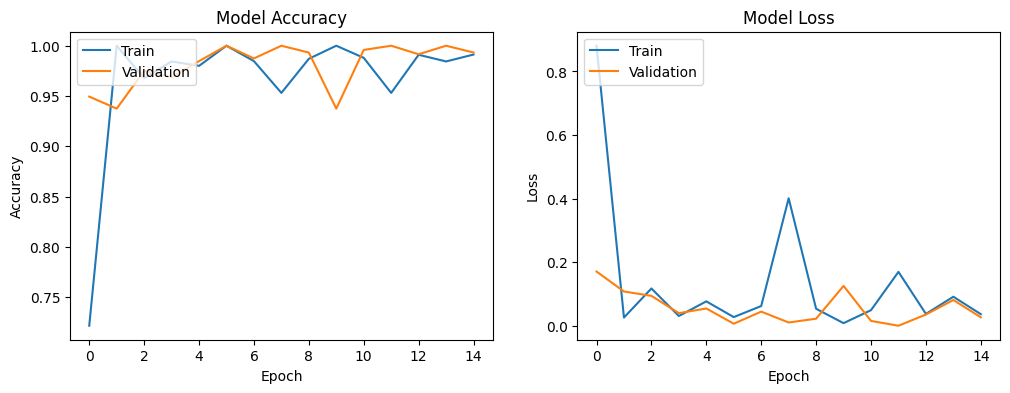

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()